# Hospital-onset COVID data - Scotland

This notebook attempts to combine data from [Public Health Scotland](https://publichealthscotland.scot/publications/hospital-onset-covid-19-cases-in-scotland/hospital-onset-covid-19-cases-in-scotland-week-ending-01-march-2020-to-week-ending-04-december-2022/) and the [ONS COVID-19 survey](https://www.ons.gov.uk/peoplepopulationandcommunity/healthandsocialcare/conditionsanddiseases/datasets/covid19infectionsurveyscotland) to estimate if nosocomial COVID, as defined by a new COVID-19 diagnosis ≥7d after admission to a hospital, is changing relative to levels of community transmission as measured by the ONS survey.

- In addition to the PDF reports, Public Health Scotland provides the data in downloadable format for [hospital-onset cases](https://www.opendata.nhs.scot/dataset/hospital-onset-covid-19-cases-in-scotland) and [all COVID-19 admissions](https://www.opendata.nhs.scot/dataset/covid-19-in-scotland/resource/bb4d083b-7b92-4722-85a3-a9b58af1f794).

The ONS survey attempts to estimate the positivity rate of COVID-19 nasal PCRs in the entire private residential population of the UK, both with and without symptoms. This involves repeatedly testing tens of thousands of individuals from households sampled randomly from a large database of addresses. Sample collection was initially facilitated by study worker home visits, which were eventually transitioned to dropoffs and self-collection. Some of the participants also provided blood samples for serologies. Detailed methods are in [this article](https://www.thelancet.com/journals/lanpub/article/PIIS2468-2667(20)30282-6/fulltext).

- Of note, [Public Health Scotland states](https://publichealthscotland.scot/our-blog/2022/september/why-we-are-changing-our-covid-19-reporting/) that "the ONS COVID Infection Survey information [...] is currently the most robust measure of community COVID-19 prevalence in Scotland" and uses it in their public weekly reports in place of healthcare system testing data.

We use positivity rate in the residential population as a proxy for community transmission rates. (Nosocomial transmission is [expected to correlate with community transmission](https://pubmed.ncbi.nlm.nih.gov/36738991/).) We do this because we are interested in changes surrounding the discontinuation of screening all asymptomatic admissions, which took place on [Sept 28 2002 in Scotland](https://www.gov.scot/news/pausing-asymptomatic-covid-19-testing/). This is approximately [1 month after England did so](https://www.gov.uk/government/news/regular-asymptomatic-testing-paused-in-additional-settings). On Twitter, it [has been reported](https://twitter.com/AdeleGroyer/status/1605876274337046530) that the proportion of nosocomial cases relative to all inpatient COVID-19 cases has increased since this change (orange line). However, since the denominator of all cases may be expected to shrink under the new testing strategy, we decided to re-normalize the nosocomial case counts against community positivity levels; serial testing for the ONS survey should not be affected by the new testing strategy in hospitals.

In [1]:
suppressMessages({
    require(plyr)
    require(tidyverse)
    require(data.table)
    require(readxl)
    require(viridis)
    require(ggplot2)
    require(yaml)
    require(cowplot)
    require(lubridate)
})

options(repr.plot.res=224)

First, obtain the data on all COVID admissions to Scotland hospitals.

This data is provided as daily counts. The [Dashboard notes](https://publichealthscotland.scot/media/15323/coviddailydashboardnotes.pdf) suggests that prior versions of these data included hospital onset cases, but then goes on to say:

>September 22nd 2022 update: Hospital admissions methodology has been refined to capture
>clinical discharge diagnoses as a more robust indicator of COVID-19 related admissions.
>PHS has restricted hospital admissions to medical specialities for those with community
>acquired, PCR confirmed infections (and excluding emergency admissions for injuries)

Community acquired appears to be judged by testing positive up to 14 days before or 2 days after admission, per an accompanying [blog post](https://publichealthscotland.scot/our-blog/2022/september/why-we-are-changing-our-covid-19-reporting/). By manually comparing the blog post's figure with my own weekly counts, it looks like this new definition (green line) was applied retrospectively to all prior weeks. Therefore, I'll consider these counts to be community-onset only (and most "incidental" COVID is being excluded by the use of discharge diagnoses).

In [2]:
dt.covid_admits_daily <- fread('data/Scotland-covid19-admissions/daily_covid_admissions.csv')
dt.covid_admits_daily[, Date := ymd(Date)]
head(dt.covid_admits_daily)

Date,NumberAdmitted,SevenDayAverage,SevenDayAverageQF
<date>,<int>,<dbl>,<chr>
2020-03-01,1,NA,z
2020-03-03,1,NA,z
2020-03-04,1,NA,z
2020-03-05,3,NA,z
2020-03-06,4,NA,z
2020-03-07,2,NA,z


All data in the rest of this notebook are provided to us as weekly counts, so let's summarize the prior table as weekly sums.

We choose to end each week on a Sunday, since this is the convention used by Scotland's nosocomial COVID data.

We drop the last row of data because they include a week with no good overlap with the ONS data, which for Scotland, ends at Dec 8 2022. In later versions of the ONS data for Scotland, we found that this month has a gap between Dec 8 and Dec 22 (perhaps due to a period with low testing collection or processing related to winter holidays).

In [3]:
dt.covid_admits_weekly <- dt.covid_admits_daily[, .(community_onset_adm_count = sum(NumberAdmitted)),
    keyby = .(week_ending_date = 7 * as.numeric(Date - min(Date) - 1) %/% 7 + 6 + min(Date) + 1)]
dt.covid_admits_weekly <- head(dt.covid_admits_weekly, -1)
head(dt.covid_admits_weekly)
tail(dt.covid_admits_weekly)

week_ending_date,community_onset_adm_count
<date>,<int>
2020-03-01,1
2020-03-08,12
2020-03-15,57
2020-03-22,209
2020-03-29,718
2020-04-05,1069


week_ending_date,community_onset_adm_count
<date>,<int>
2022-11-20,149
2022-11-27,193
2022-12-04,182
2022-12-11,236
2022-12-18,304
2022-12-25,422


Next, extract the nosocomial COVID data (which is weekly) from the Public Health Scotland open data export

Nosocomial is split into two columns, Probable (>7-14d) and Definite (>14d); for parity with the NHS England data, which used >7d, we'll combine them into one category.

In [4]:
dt.noso_covid <- fread('data/Scotland-covid19-admissions/hospitalonsetcovid_opendata.csv')
dt.noso_covid[, week_ending_date := ymd(WeekEnding)]
dt.noso_covid[, hospital_onset_adm_count := ProbableHospitalOnsetCOVID19 + DefiniteHospitalOnsetCOVID19]
tail(dt.noso_covid)

Country,WeekEnding,WeekNumber,ProbableHospitalOnsetCOVID19,DefiniteHospitalOnsetCOVID19,week_ending_date,hospital_onset_adm_count
<chr>,<int>,<int>,<int>,<int>,<date>,<int>
S92000003,20221113,45,64,119,2022-11-13,183
S92000003,20221120,46,25,79,2022-11-20,104
S92000003,20221127,47,43,96,2022-11-27,139
S92000003,20221204,48,72,144,2022-12-04,216
S92000003,20221211,49,48,203,2022-12-11,251
S92000003,20221218,50,80,232,2022-12-18,312


Let's join this to the total COVID admissions table. All rows join successfully.

In [5]:
dt.covid_admits <- dt.covid_admits_weekly[dt.noso_covid, on = "week_ending_date"]
dt.covid_admits[, total_covid_adm_count := community_onset_adm_count + hospital_onset_adm_count]
nrow(dt.covid_admits[is.na(total_covid_adm_count), ])
head(dt.covid_admits)

[1] 0

week_ending_date,community_onset_adm_count,Country,WeekEnding,WeekNumber,ProbableHospitalOnsetCOVID19,DefiniteHospitalOnsetCOVID19,hospital_onset_adm_count,total_covid_adm_count
<date>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>
2020-03-15,57,S92000003,20200315,11,3,4,7,64
2020-03-22,209,S92000003,20200322,12,11,28,39,248
2020-03-29,718,S92000003,20200329,13,29,96,125,843
2020-04-05,1069,S92000003,20200405,14,29,218,247,1316
2020-04-12,765,S92000003,20200412,15,48,207,255,1020
2020-04-19,507,S92000003,20200419,16,39,174,213,720


**WARNING** There were some missing weeks in the nosocomial COVID table, all from May 2021 or earlier. Joining in the manner above means we simply will have to leave those weeks out of downstream analysis and plots.

This query shows which weeks were missing:

In [6]:
dt.noso_covid[dt.covid_admits_weekly, on = "week_ending_date"][
    is.na(ProbableHospitalOnsetCOVID19) & 
        week_ending_date <= max(dt.covid_admits$week_ending_date) &
        week_ending_date >= min(dt.covid_admits$week_ending_date), 
    .(week_ending_date, community_onset_adm_count, hospital_onset_adm_count)
]

week_ending_date,community_onset_adm_count,hospital_onset_adm_count
<date>,<int>,<int>
2020-07-05,5,NA
2020-07-19,4,NA
2020-07-26,3,NA
2020-08-02,3,NA
2020-08-23,12,NA
2020-09-13,37,NA
2021-05-02,53,NA
2021-05-16,57,NA


Of note, all of these weeks are well before universal admission testing ended in Sept 2022.

Next, we import the ONS survey data for estimated COVID-19 positivity, plucking out the columns for Scotland specifically. ONS started surveying Scotland a bit later than England (October 2020 vs April 2020).

Similar to the England data, the ONS survey "weeks" don't end on a consistent day of the week, so we have to use a rolling join to the nearest date.

In [7]:
path.xl <- 'data/ONS-covid19-survey/20221223covid19infectionsurveydatasetsscotland22122022142829.xlsx'
ons_col_names <- c("date_range", 
        "est_pct_positive", "est_pct_positive_ci95_lo", "est_pct_positive_ci95_hi",
        "est_pop_positive", "est_pop_positive_ci95_lo", "est_pop_positive_ci95_hi",
        "est_ratio_positive", "est_ratio_positive_ci95_lo", "est_ratio_positive_ci95_hi")
suppressMessages({
    dt.covid_survey <- as.data.table(read_excel(path.xl, sheet = 7, range = "A6:J119", col_names = ons_col_names))
})
dt.covid_survey[
    ,
    ':='(
       date_lo = dmy(str_split_fixed(date_range, " to ", 2)[, 1]),
       date_hi = dmy(str_split_fixed(date_range, " to ", 2)[, 2]),
       # This is the date column we will do the rolling join on (== date_hi)
       # We don't simply use date_hi, so we can preserve the original value of date_hi before the rolling join
       date = dmy(str_split_fixed(date_range, " to ", 2)[, 2]) 
    )
]
last_ons_date <- max(dt.covid_survey$date_hi)
head(dt.covid_survey)
tail(dt.covid_survey)
last_ons_date

date_range,est_pct_positive,est_pct_positive_ci95_lo,est_pct_positive_ci95_hi,est_pop_positive,est_pop_positive_ci95_lo,est_pop_positive_ci95_hi,est_ratio_positive,est_ratio_positive_ci95_lo,est_ratio_positive_ci95_hi,date_lo,date_hi,date
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<date>,<date>,<date>
03 October 2020 to 16 October 2020,0.57,0.35,0.88,29900,18200,46200,1 in 180,1 in 290,1 in 110,2020-10-03,2020-10-16,2020-10-16
10 October 2020 to 23 October 2020,0.71,0.48,1.01,37400,25300,53300,1 in 140,1 in 210,1 in 100,2020-10-10,2020-10-23,2020-10-23
18 October 2020 to 31 October 2020,0.90,0.63,1.24,47300,33200,65300,1 in 110,1 in 160,1 in 80,2020-10-18,2020-10-31,2020-10-31
31 October 2020 to 06 November 2020,0.75,0.54,1.00,39700,28300,52800,1 in 130,1 in 190,1 in 100,2020-10-31,2020-11-06,2020-11-06
08 November 2020 to 14 November 2020,0.64,0.45,0.86,33800,23600,45300,1 in 160,1 in 220,1 in 120,2020-11-08,2020-11-14,2020-11-14
15 November 2020 to 21 November 2020,0.87,0.67,1.10,45700,35000,58100,1 in 120,1 in 150,1 in 90,2020-11-15,2020-11-21,2020-11-21


date_range,est_pct_positive,est_pct_positive_ci95_lo,est_pct_positive_ci95_hi,est_pop_positive,est_pop_positive_ci95_lo,est_pop_positive_ci95_hi,est_ratio_positive,est_ratio_positive_ci95_lo,est_ratio_positive_ci95_hi,date_lo,date_hi,date
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<date>,<date>,<date>
02 November 2022 to 08 November 2022,1.85,1.54,2.20,97500,81100,115900,1 in 55,1 in 65,1 in 45,2022-11-02,2022-11-08,2022-11-08
09 November 2022 to 15 November 2022,1.59,1.27,1.95,83700,67000,102500,1 in 65,1 in 80,1 in 50,2022-11-09,2022-11-15,2022-11-15
15 November 2022 to 21 November 2022,1.73,1.41,2.09,91100,74000,110100,1 in 60,1 in 70,1 in 50,2022-11-15,2022-11-21,2022-11-21
18 November 2022 to 24 November 2022,1.68,1.35,2.03,88500,71000,106800,1 in 60,1 in 75,1 in 50,2022-11-18,2022-11-24,2022-11-24
29 November 2022 to 05 December 2022,1.91,1.54,2.31,100700,81300,121800,1 in 50,1 in 65,1 in 45,2022-11-29,2022-12-05,2022-12-05
02 December 2022 to 08 December 2022,2.49,2.11,2.91,130900,111100,153400,1 in 40,1 in 45,1 in 35,2022-12-02,2022-12-08,2022-12-08


[1] "2022-12-08"

In [8]:
dt.joined <- dt.covid_survey[dt.covid_admits, on = .(date == week_ending_date), roll = "nearest"]
dt.joined[, hospital_onset_adm_count := total_covid_adm_count - community_onset_adm_count]
dt.joined[, hospital_onset_ratio := hospital_onset_adm_count / total_covid_adm_count]
dt.joined[, hospital_onset_vs_comm_ratio := hospital_onset_adm_count / community_onset_adm_count]
dt.joined[, hospital_onset_vs_comm_positivity := hospital_onset_adm_count / est_pct_positive]
dt.joined[, hospital_onset_vs_comm_positives := hospital_onset_adm_count / est_pop_positive]
dt.joined[, hospital_onset_vs_comm_positives_ci95_hi := hospital_onset_adm_count / est_pop_positive_ci95_lo]
dt.joined[, hospital_onset_vs_comm_positives_ci95_lo := hospital_onset_adm_count / est_pop_positive_ci95_hi]

After December 8, there are no more ONS data for Scotland. We don't want to keep joining future admissions data (beyond ~7d or so) to the last row of ONS data, so best to just drop them.

In [9]:
dt.joined <- dt.joined[date <= last_ons_date + 7, ]
head(dt.joined)
tail(dt.joined[, .(date_range, date)])

date_range,est_pct_positive,est_pct_positive_ci95_lo,est_pct_positive_ci95_hi,est_pop_positive,est_pop_positive_ci95_lo,est_pop_positive_ci95_hi,est_ratio_positive,est_ratio_positive_ci95_lo,est_ratio_positive_ci95_hi,⋯,ProbableHospitalOnsetCOVID19,DefiniteHospitalOnsetCOVID19,hospital_onset_adm_count,total_covid_adm_count,hospital_onset_ratio,hospital_onset_vs_comm_ratio,hospital_onset_vs_comm_positivity,hospital_onset_vs_comm_positives,hospital_onset_vs_comm_positives_ci95_hi,hospital_onset_vs_comm_positives_ci95_lo
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,⋯,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
03 October 2020 to 16 October 2020,0.57,0.35,0.88,29900,18200,46200,1 in 180,1 in 290,1 in 110,⋯,3,4,7,64,0.1093750,0.1228070,12.28070,0.0002341137,0.0003846154,0.0001515152
03 October 2020 to 16 October 2020,0.57,0.35,0.88,29900,18200,46200,1 in 180,1 in 290,1 in 110,⋯,11,28,39,248,0.1572581,0.1866029,68.42105,0.0013043478,0.0021428571,0.0008441558
03 October 2020 to 16 October 2020,0.57,0.35,0.88,29900,18200,46200,1 in 180,1 in 290,1 in 110,⋯,29,96,125,843,0.1482800,0.1740947,219.29825,0.0041806020,0.0068681319,0.0027056277
03 October 2020 to 16 October 2020,0.57,0.35,0.88,29900,18200,46200,1 in 180,1 in 290,1 in 110,⋯,29,218,247,1316,0.1876900,0.2310571,433.33333,0.0082608696,0.0135714286,0.0053463203
03 October 2020 to 16 October 2020,0.57,0.35,0.88,29900,18200,46200,1 in 180,1 in 290,1 in 110,⋯,48,207,255,1020,0.2500000,0.3333333,447.36842,0.0085284281,0.0140109890,0.0055194805
03 October 2020 to 16 October 2020,0.57,0.35,0.88,29900,18200,46200,1 in 180,1 in 290,1 in 110,⋯,39,174,213,720,0.2958333,0.4201183,373.68421,0.0071237458,0.0117032967,0.0046103896


date_range,date
<chr>,<date>
02 November 2022 to 08 November 2022,2022-11-06
09 November 2022 to 15 November 2022,2022-11-13
15 November 2022 to 21 November 2022,2022-11-20
18 November 2022 to 24 November 2022,2022-11-27
29 November 2022 to 05 December 2022,2022-12-04
02 December 2022 to 08 December 2022,2022-12-11


This means the last row of weekly data from Scotland will be tied to Dec 11 2022.

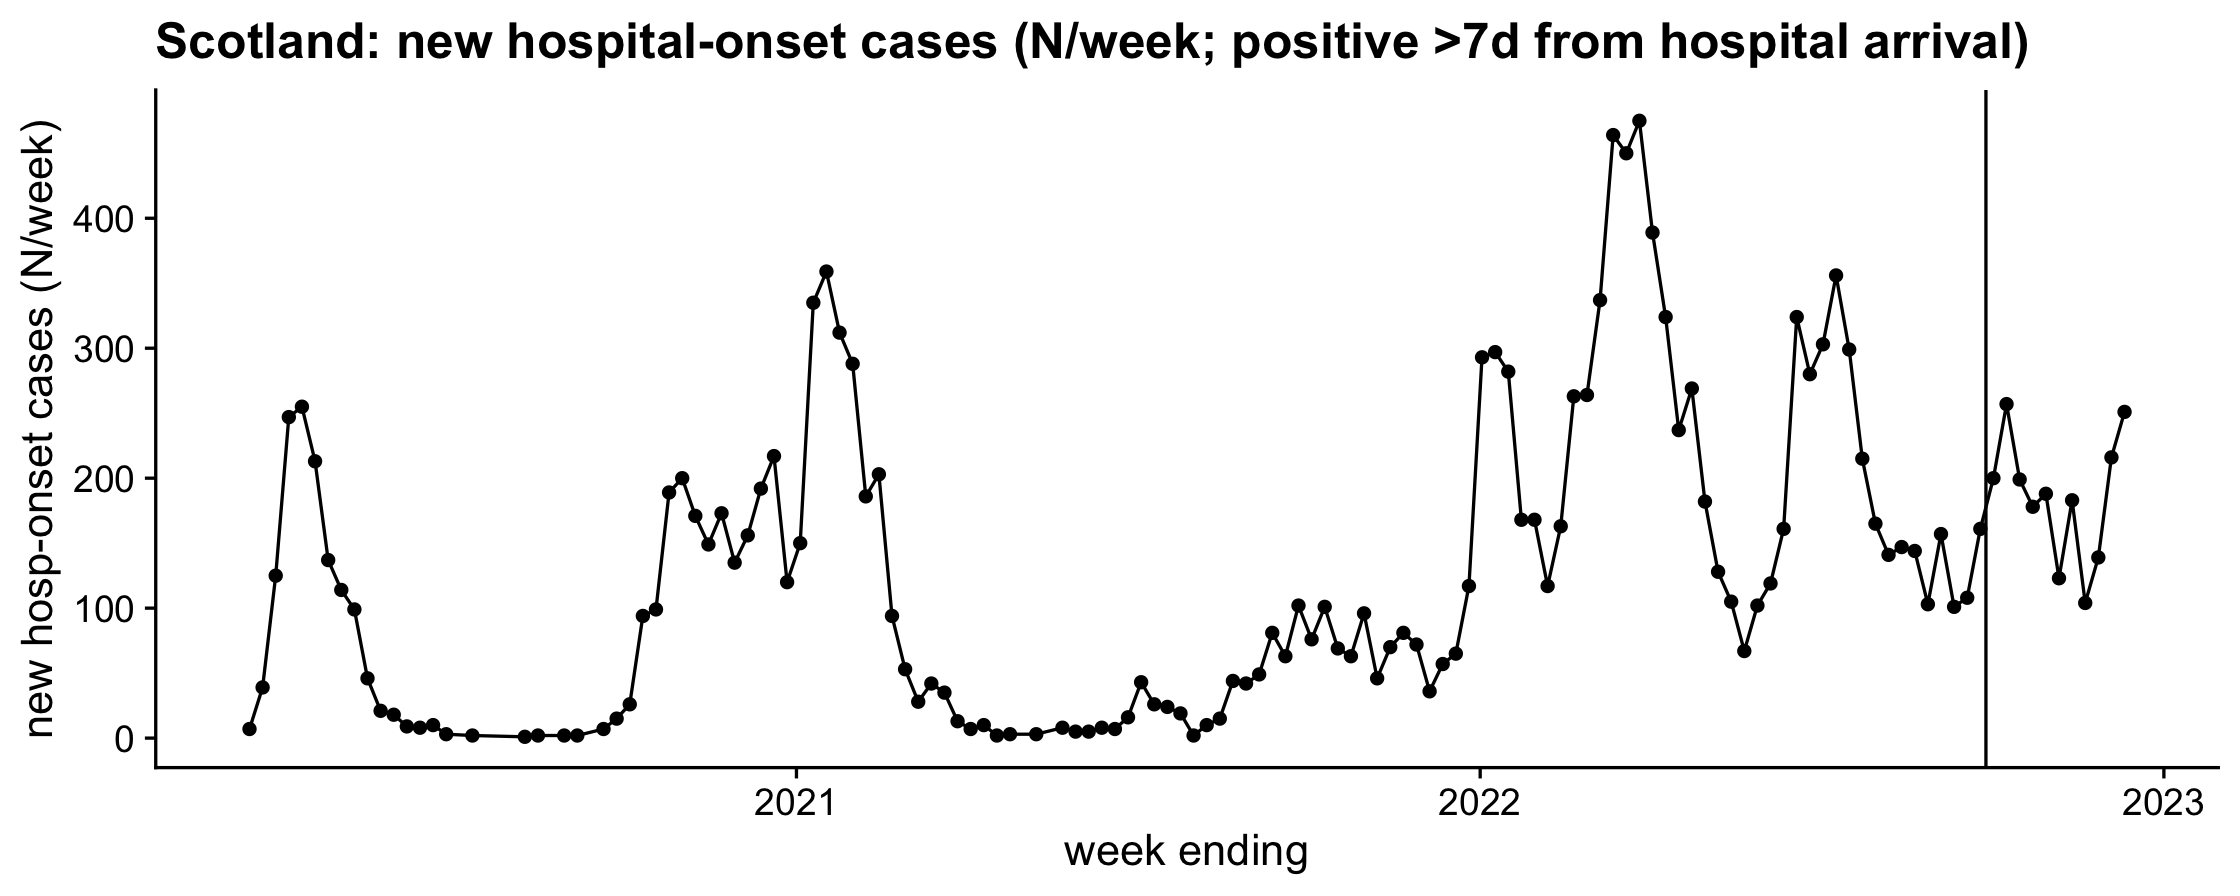

In [10]:
options(repr.plot.width=10, repr.plot.height=4)
ggplot(dt.joined, aes(x=date, y=hospital_onset_adm_count)) +
    geom_line() + geom_point() +
    geom_vline(xintercept = as.Date("2022-09-28"), linetype = "solid") +
    ylab("new hosp-onset cases (N/week)") + xlab("week ending") +
    ggtitle("Scotland: new hospital-onset cases (N/week; positive >7d from hospital arrival)") + 
    theme_cowplot()

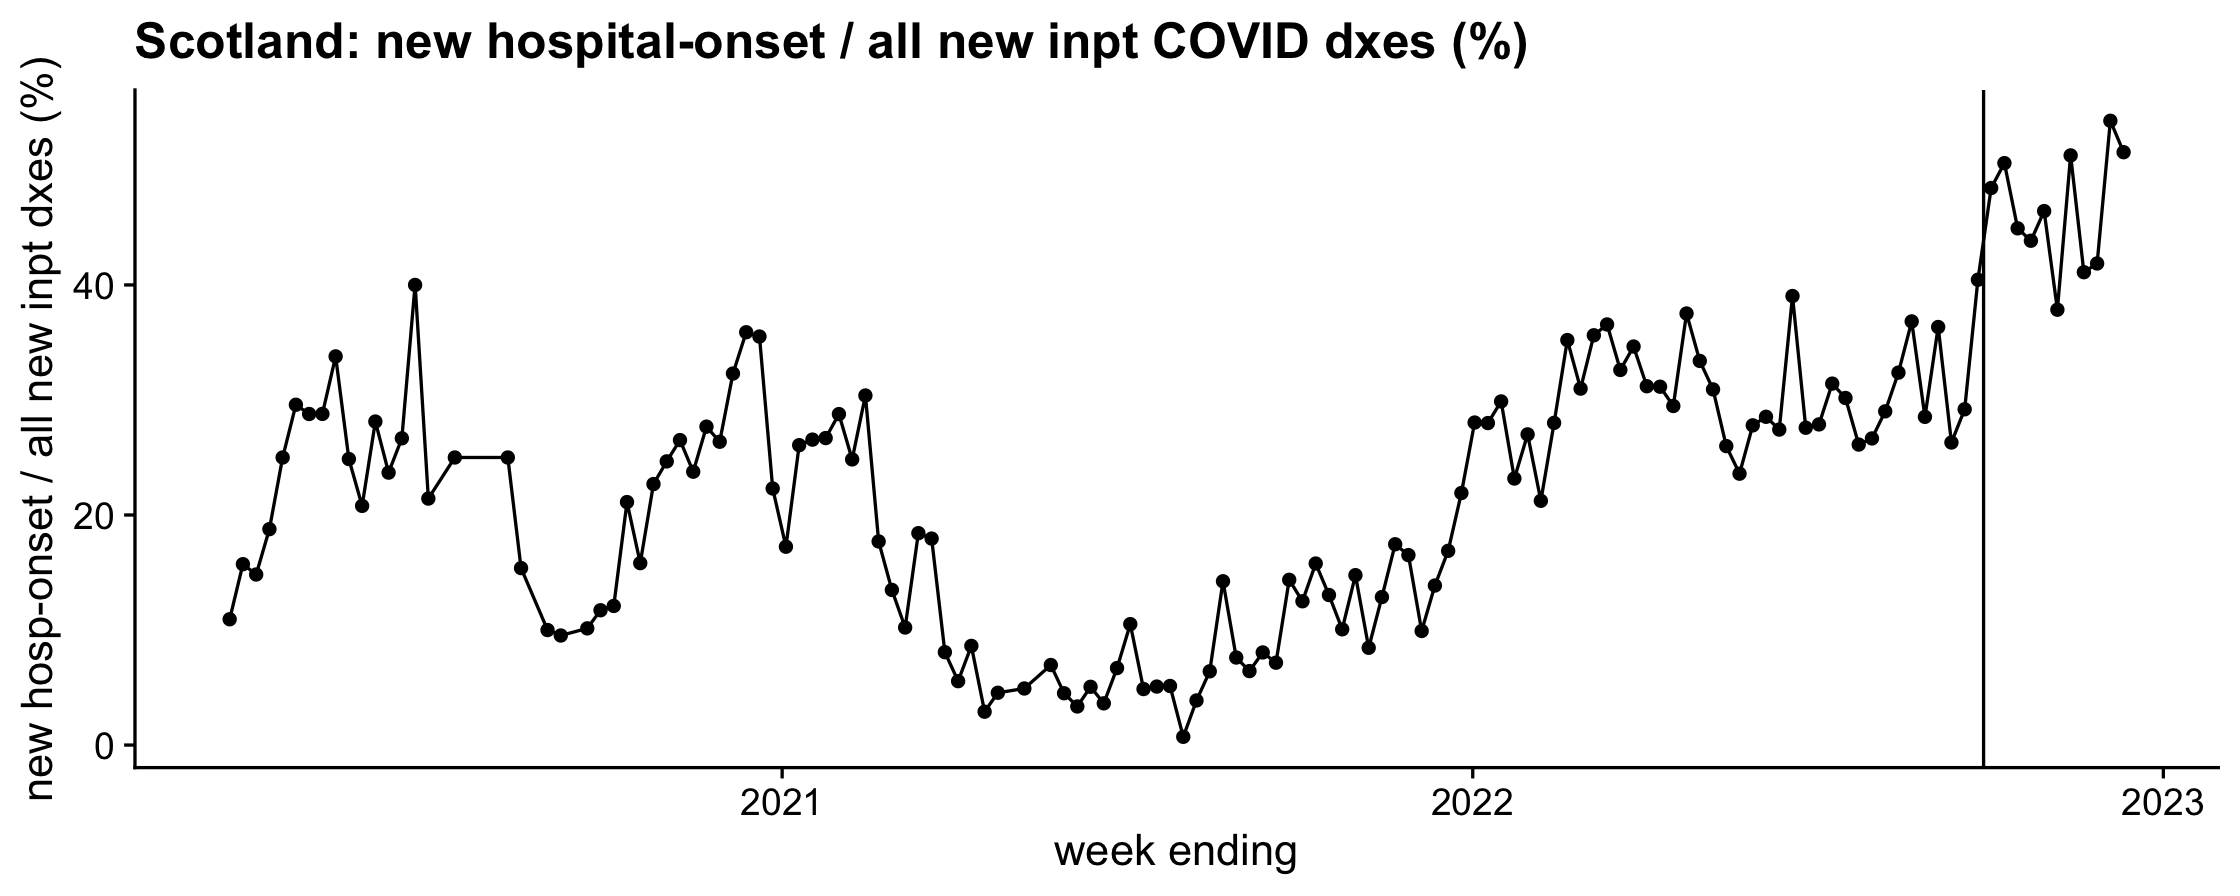

In [11]:
options(repr.plot.width=10, repr.plot.height=4)
ggplot(dt.joined, aes(x=date, y=hospital_onset_ratio * 100)) +
    geom_line() + geom_point() +
    geom_vline(xintercept = as.Date("2022-09-28"), linetype = "solid") +
    ylab("new hosp-onset / all new inpt dxes (%)") + xlab("week ending") +
    ggtitle("Scotland: new hospital-onset / all new inpt COVID dxes (%)") + 
    theme_cowplot()

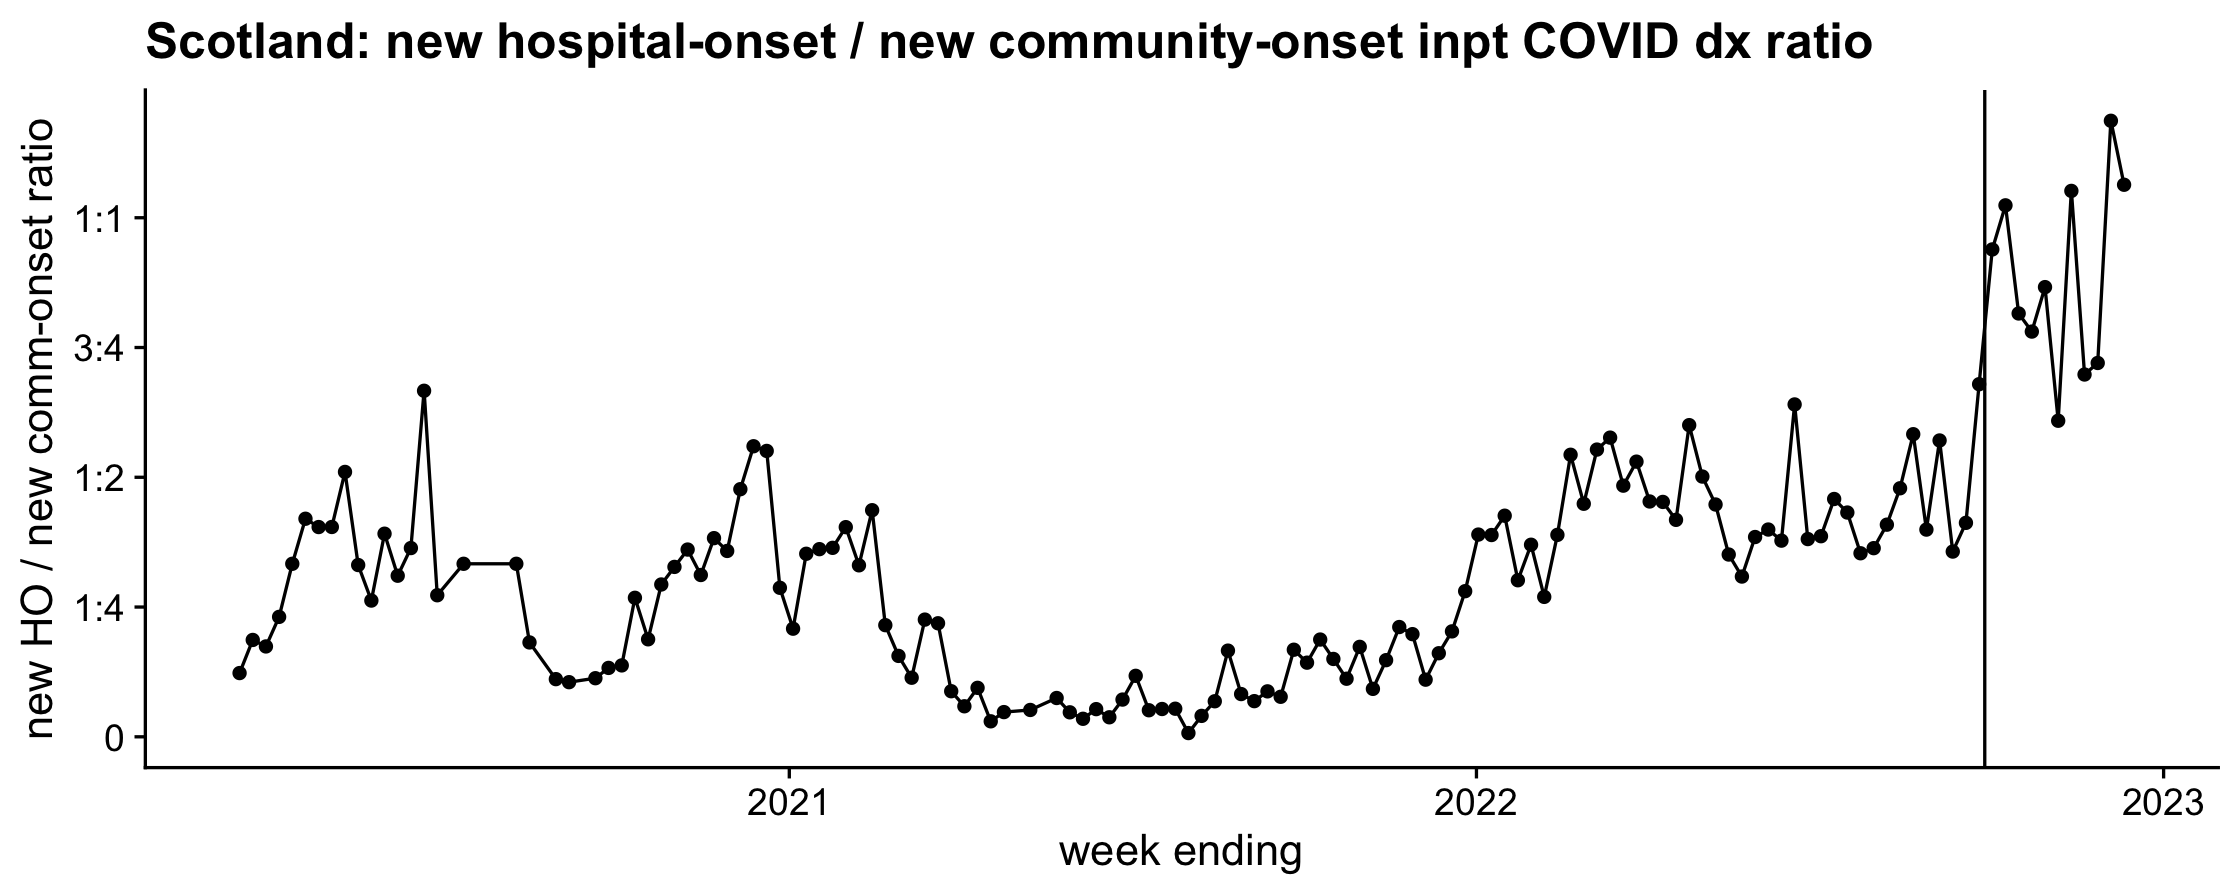

In [12]:
options(repr.plot.width=10, repr.plot.height=4)
ggplot(dt.joined, aes(x=date, y=hospital_onset_vs_comm_ratio)) +
    geom_line() + geom_point() +
    geom_vline(xintercept = as.Date("2022-09-28"), linetype = "solid") +
    scale_y_continuous(lim = c(0, NA), breaks = seq(0, 1, 1/4), labels = c("0", "1:4", "1:2", "3:4", "1:1")) +
    ylab("new HO / new comm-onset ratio") + xlab("week ending") +
    ggtitle("Scotland: new hospital-onset / new community-onset inpt COVID dx ratio") + 
    theme_cowplot()

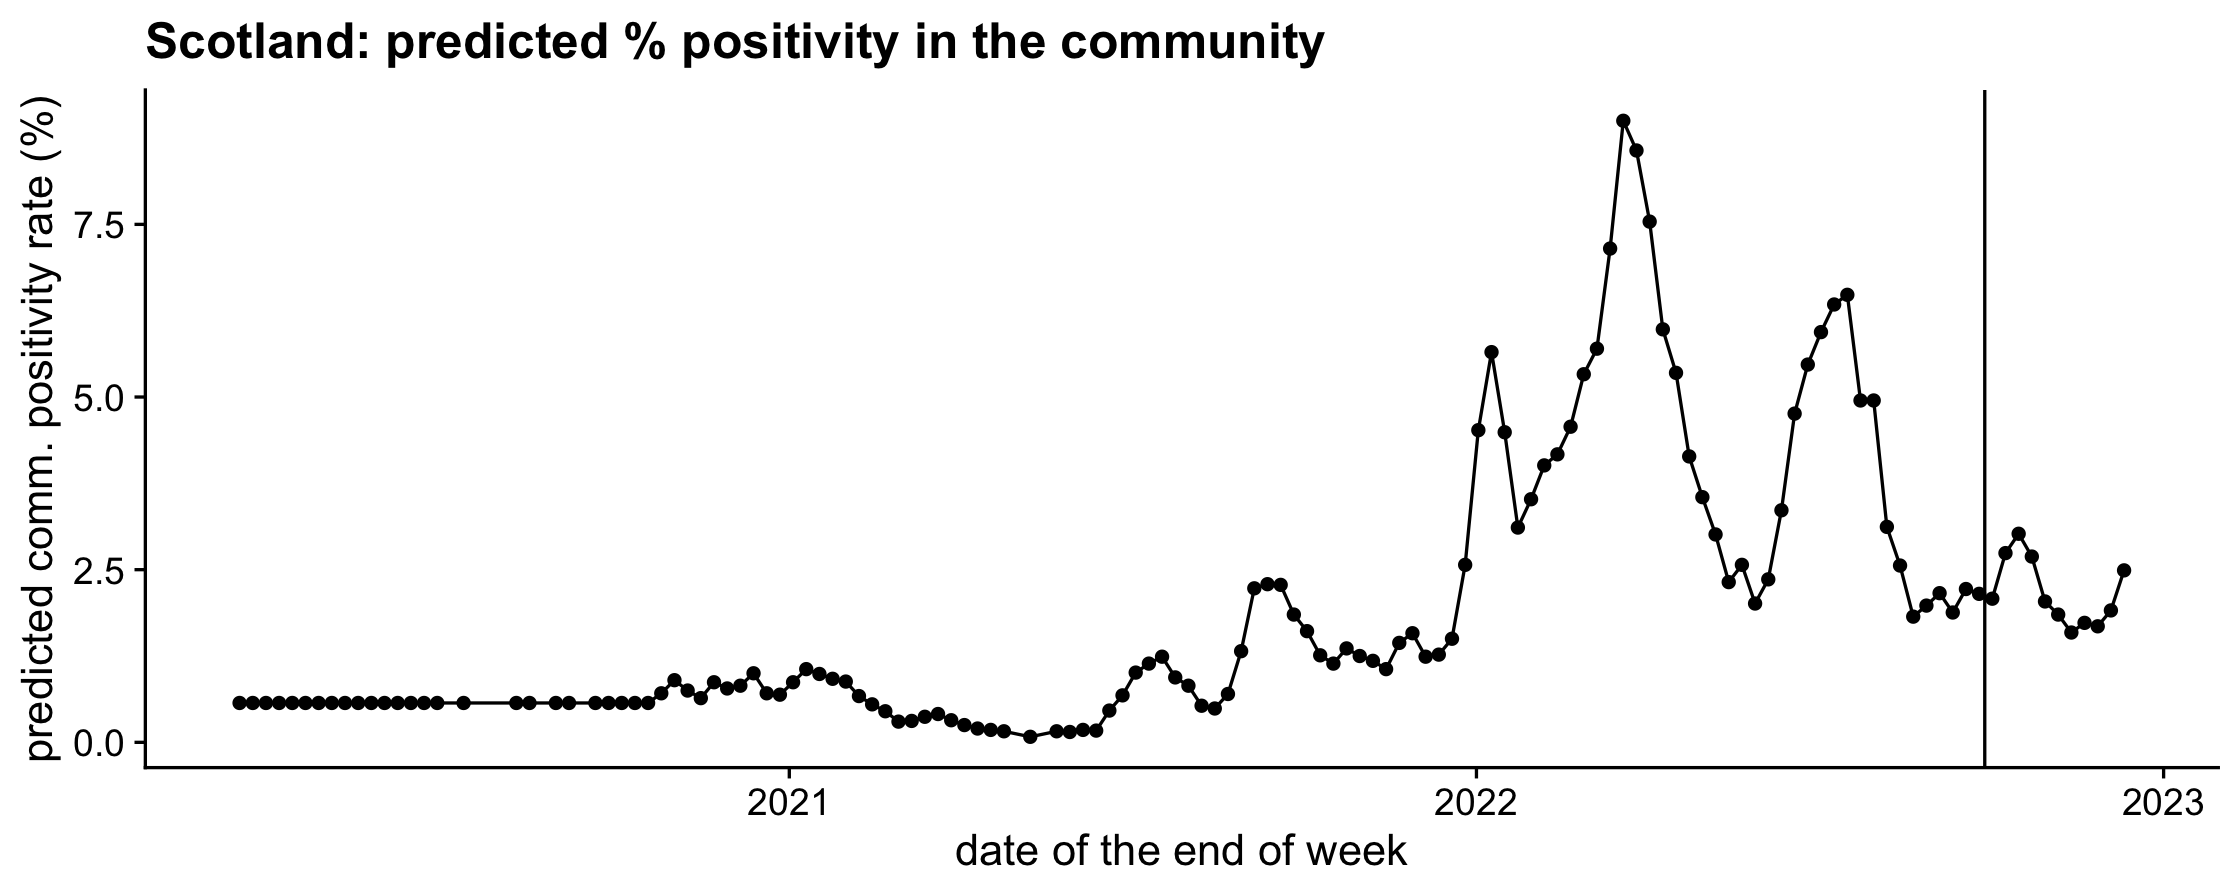

In [13]:
options(repr.plot.width=10, repr.plot.height=4)
ggplot(dt.joined, aes(x=date, y=est_pct_positive)) +
    geom_line() + geom_point() +
    geom_vline(xintercept = as.Date("2022-09-28"), linetype = "solid") +
    ylab("predicted comm. positivity rate (%)") + xlab("date of the end of week") +
    ggtitle("Scotland: predicted % positivity in the community") + 
    theme_cowplot()

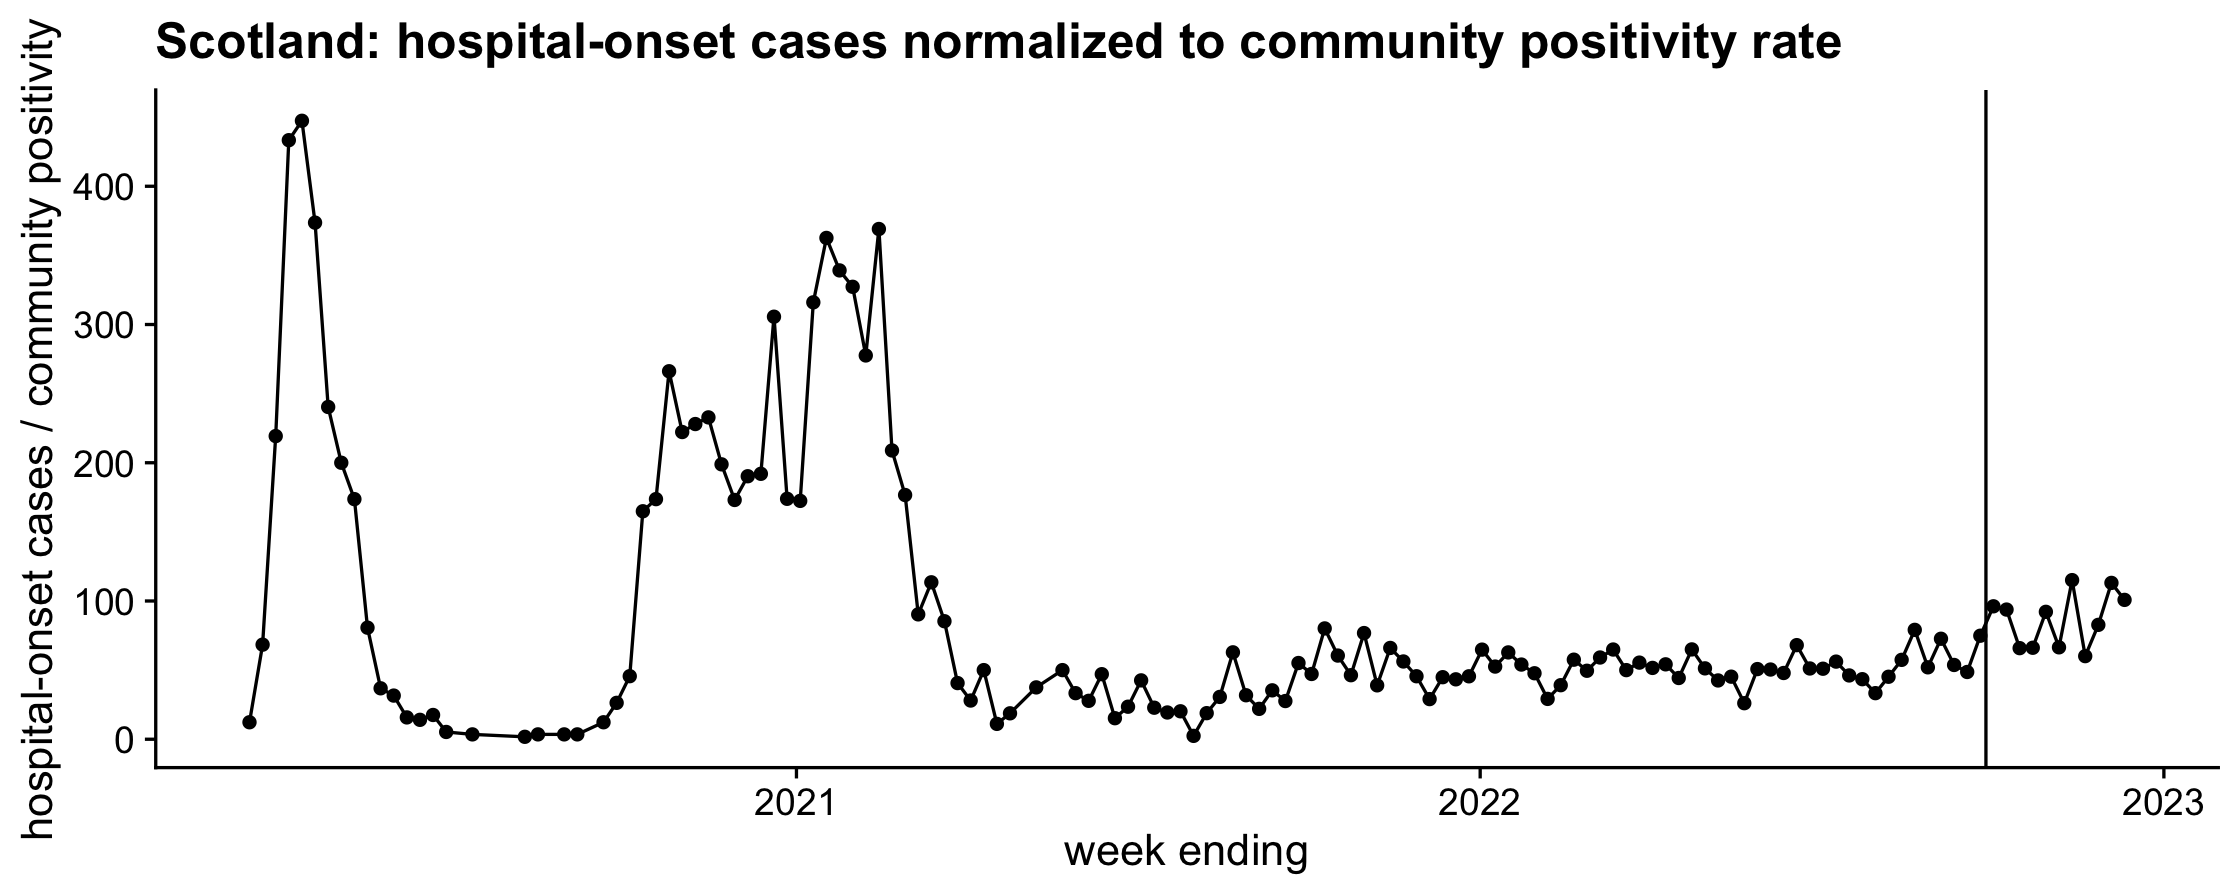

In [14]:
options(repr.plot.width=10, repr.plot.height=4)
ggplot(dt.joined, aes(x=date, y=hospital_onset_vs_comm_positivity)) +
    geom_line() + geom_point() +
    geom_vline(xintercept = as.Date("2022-09-28"), linetype = "solid") +
    ylab("hospital-onset cases / community positivity") + xlab("week ending") +
    ggtitle("Scotland: hospital-onset cases normalized to community positivity rate") + 
    theme_cowplot()

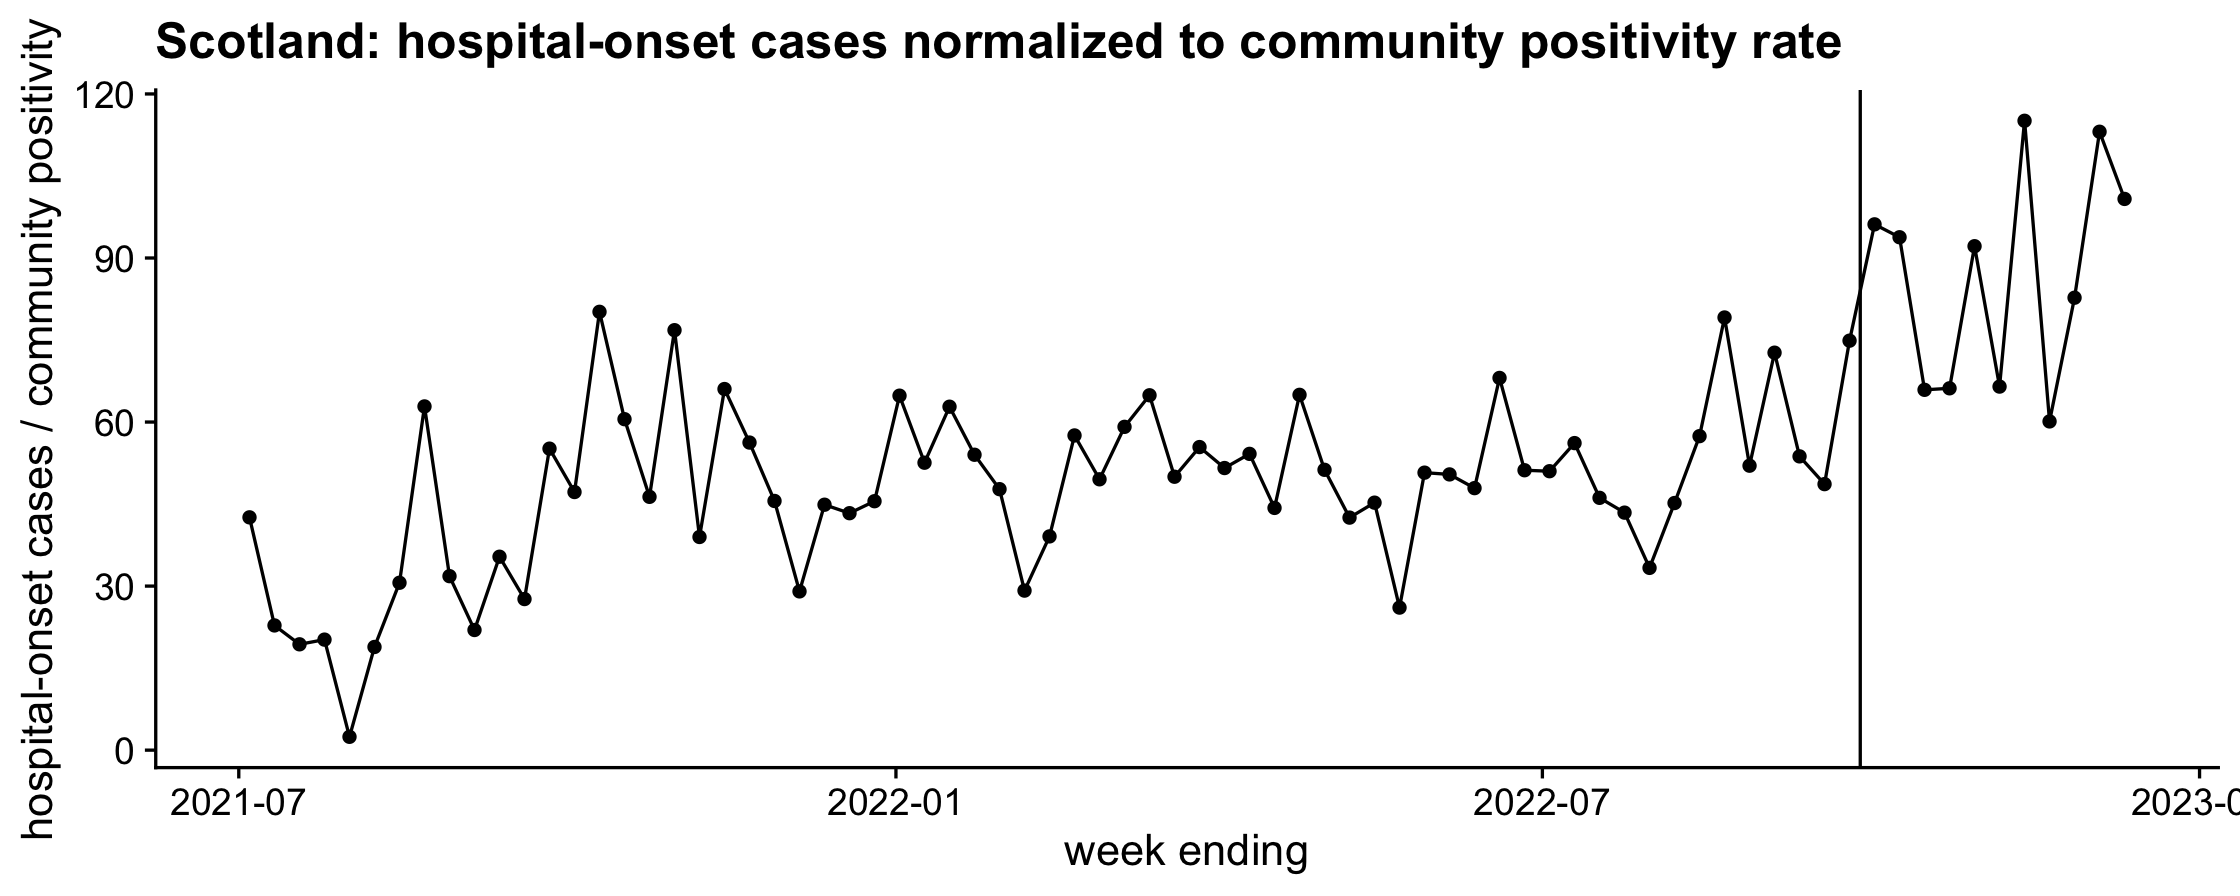

In [15]:
options(repr.plot.width=10, repr.plot.height=4)
ggplot(dt.joined[date >= as.Date('2021-07-01'), ], aes(x=date, y=hospital_onset_vs_comm_positivity)) +
    geom_line() + geom_point() +
    geom_vline(xintercept = as.Date("2022-09-28"), linetype = "solid") +
    ylab("hospital-onset cases / community positivity") + xlab("week ending") +
    ggtitle("Scotland: hospital-onset cases normalized to community positivity rate") + 
    theme_cowplot()

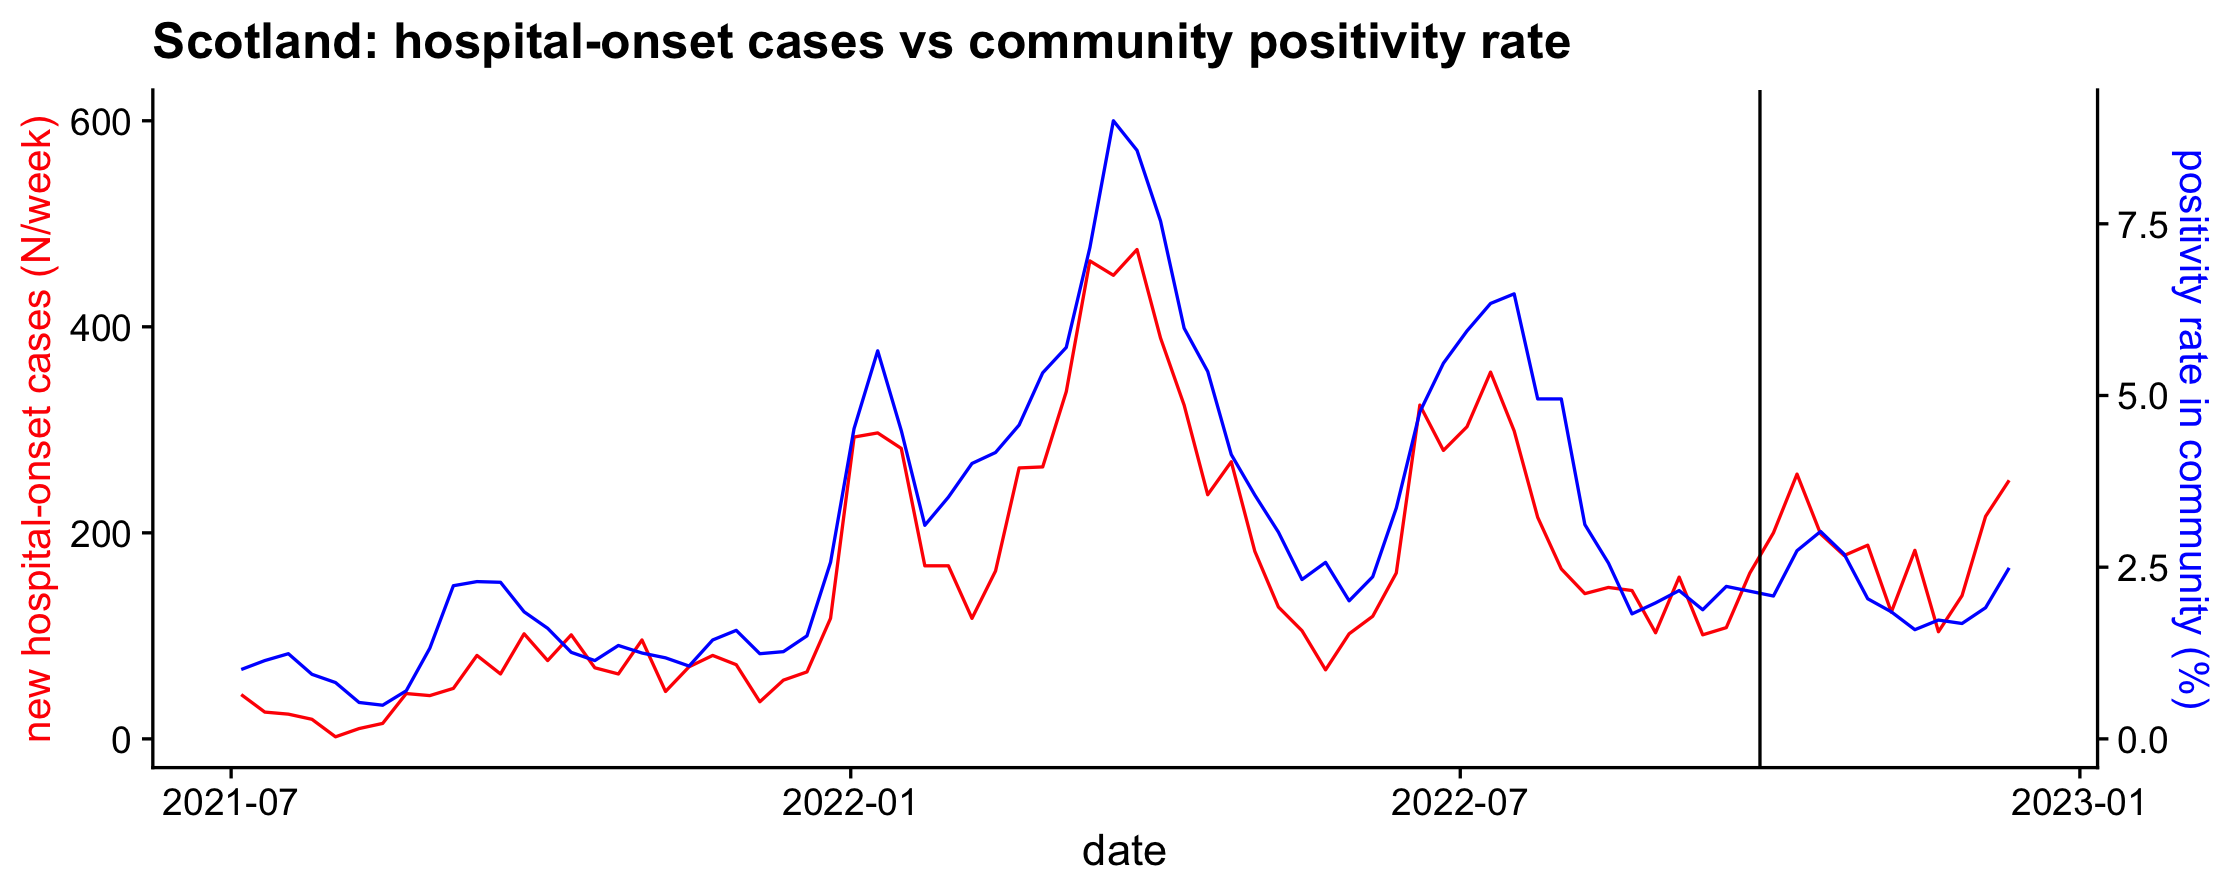

In [16]:
sec.axis.scaling <- 0.015
options(repr.plot.width=10, repr.plot.height=4)
ggplot(dt.joined[date >= as.Date('2021-07-01'), ], aes(x=date)) +
    geom_line(aes(y = hospital_onset_adm_count), color = "red") +
    geom_line(aes(y = est_pct_positive / sec.axis.scaling), color = "blue") +
    geom_vline(xintercept = as.Date("2022-09-28"), linetype = "solid") +
    scale_y_continuous(
        name = "new hospital-onset cases (N/week)",
        sec.axis = sec_axis(~ . * sec.axis.scaling, name = "positivity rate in community (%)")
    ) +
    ggtitle("Scotland: hospital-onset cases vs community positivity rate") + 
    theme_cowplot() +
    theme(
        axis.title.y = element_text(color = "red", size=13),
        axis.title.y.right = element_text(color = "blue", size=13)
    )

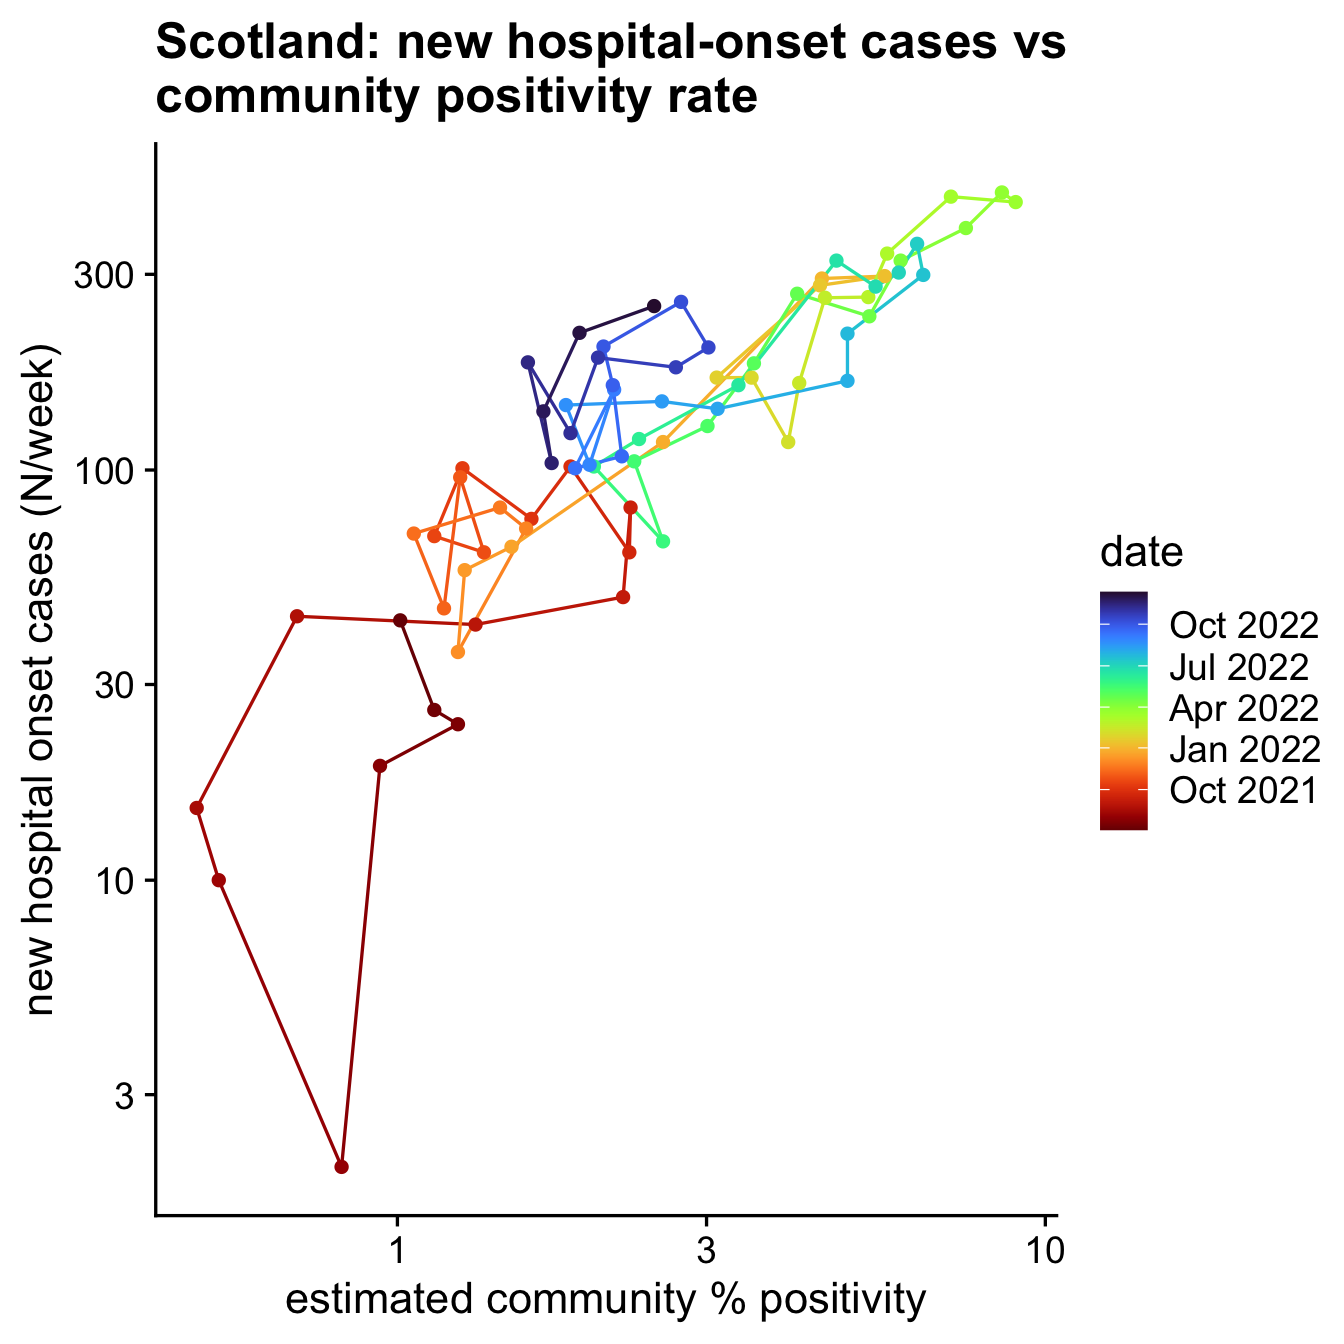

In [17]:
options(repr.plot.width=6, repr.plot.height=6)
ggplot(dt.joined[date >= as.Date('2021-07-01'), ], aes(x=est_pct_positive, y=hospital_onset_adm_count)) +
    geom_path(aes(color = date)) + geom_point(aes(color = date)) +
    scale_color_viridis(begin=1, end=0, option="turbo", trans = "date") +
    scale_x_log10() + scale_y_log10() +
    ggtitle("Scotland: new hospital-onset cases vs \ncommunity positivity rate") + 
    xlab("estimated community % positivity") + ylab("new hospital onset cases (N/week)") +
    theme_cowplot()

Let's rework some of the above using absolute population counts for predicted community positivity

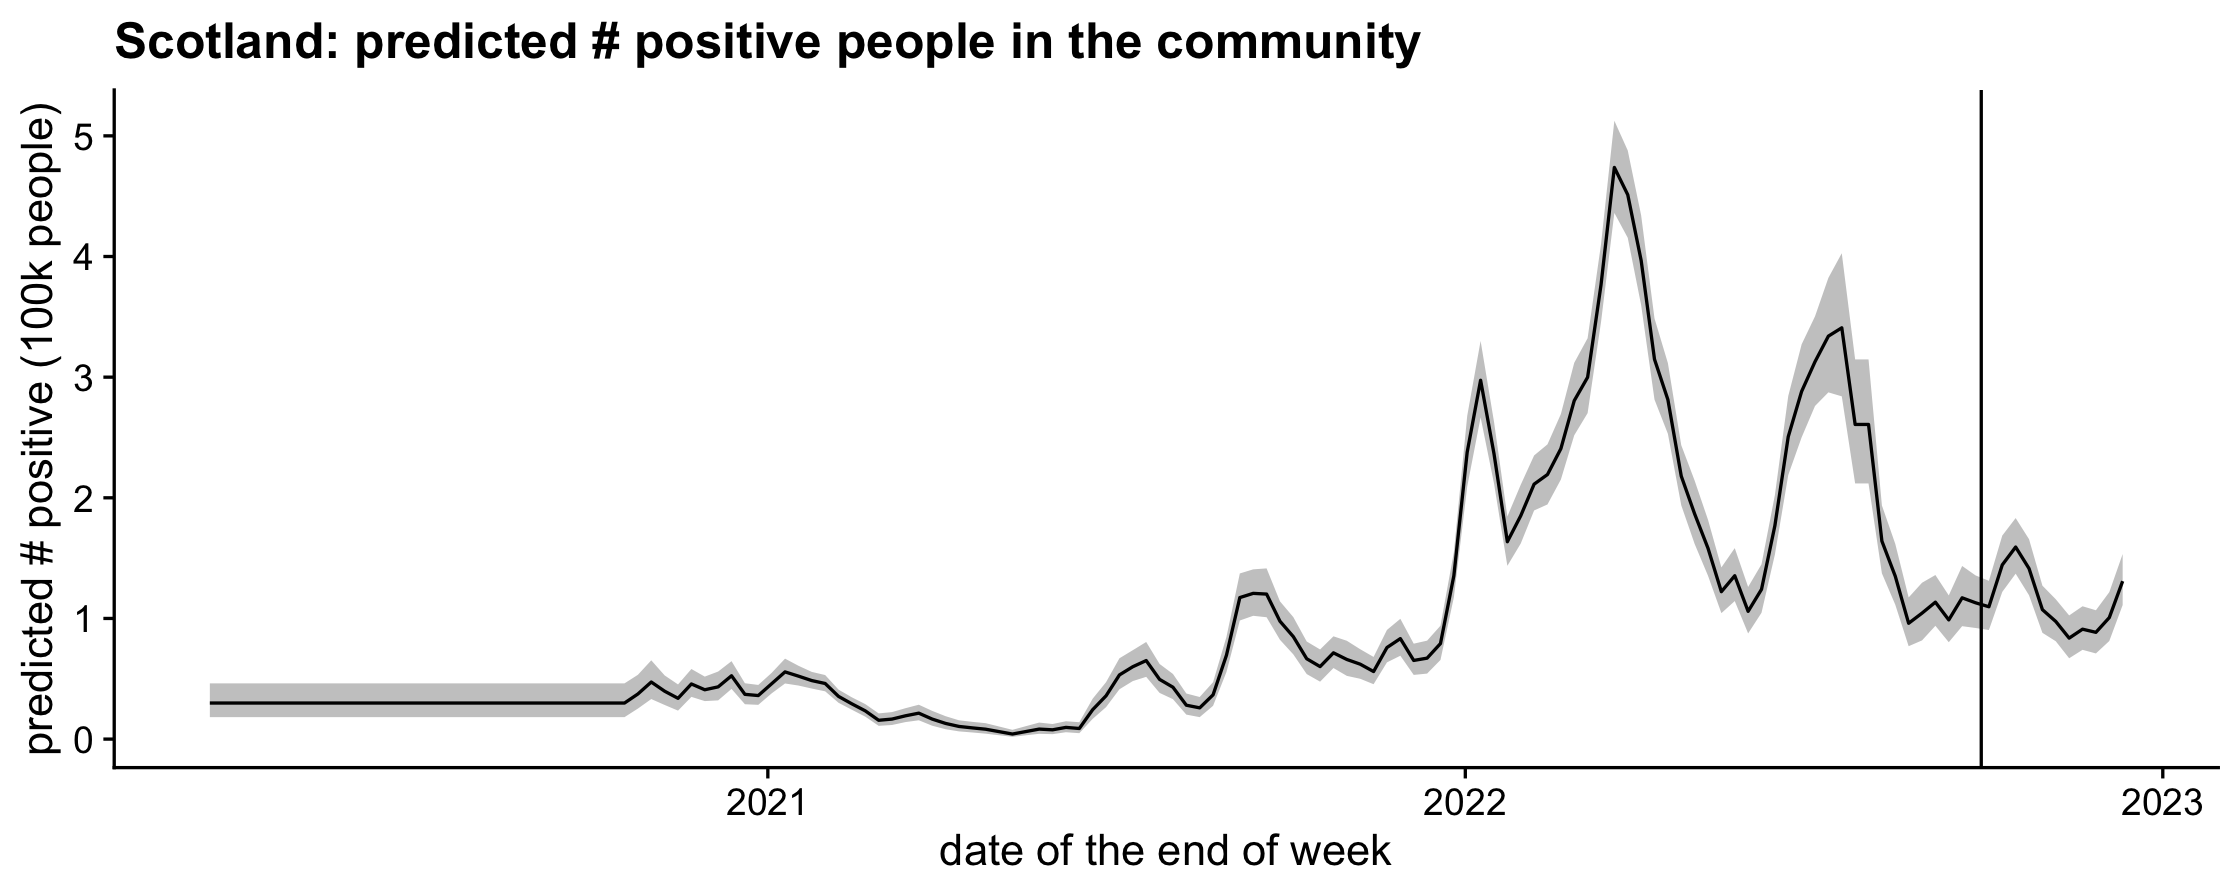

In [18]:
options(repr.plot.width=10, repr.plot.height=4)
ggplot(dt.joined, aes(x=date, y=est_pop_positive / 1e5)) +
    geom_ribbon(aes(ymin=est_pop_positive_ci95_lo / 1e5, ymax=est_pop_positive_ci95_hi / 1e5), alpha=0.3) +
    geom_line() + 
    geom_vline(xintercept = as.Date("2022-09-28"), linetype = "solid") +
    ylab("predicted # positive (100k people)") + xlab("date of the end of week") +
    ggtitle("Scotland: predicted # positive people in the community") + 
    theme_cowplot()

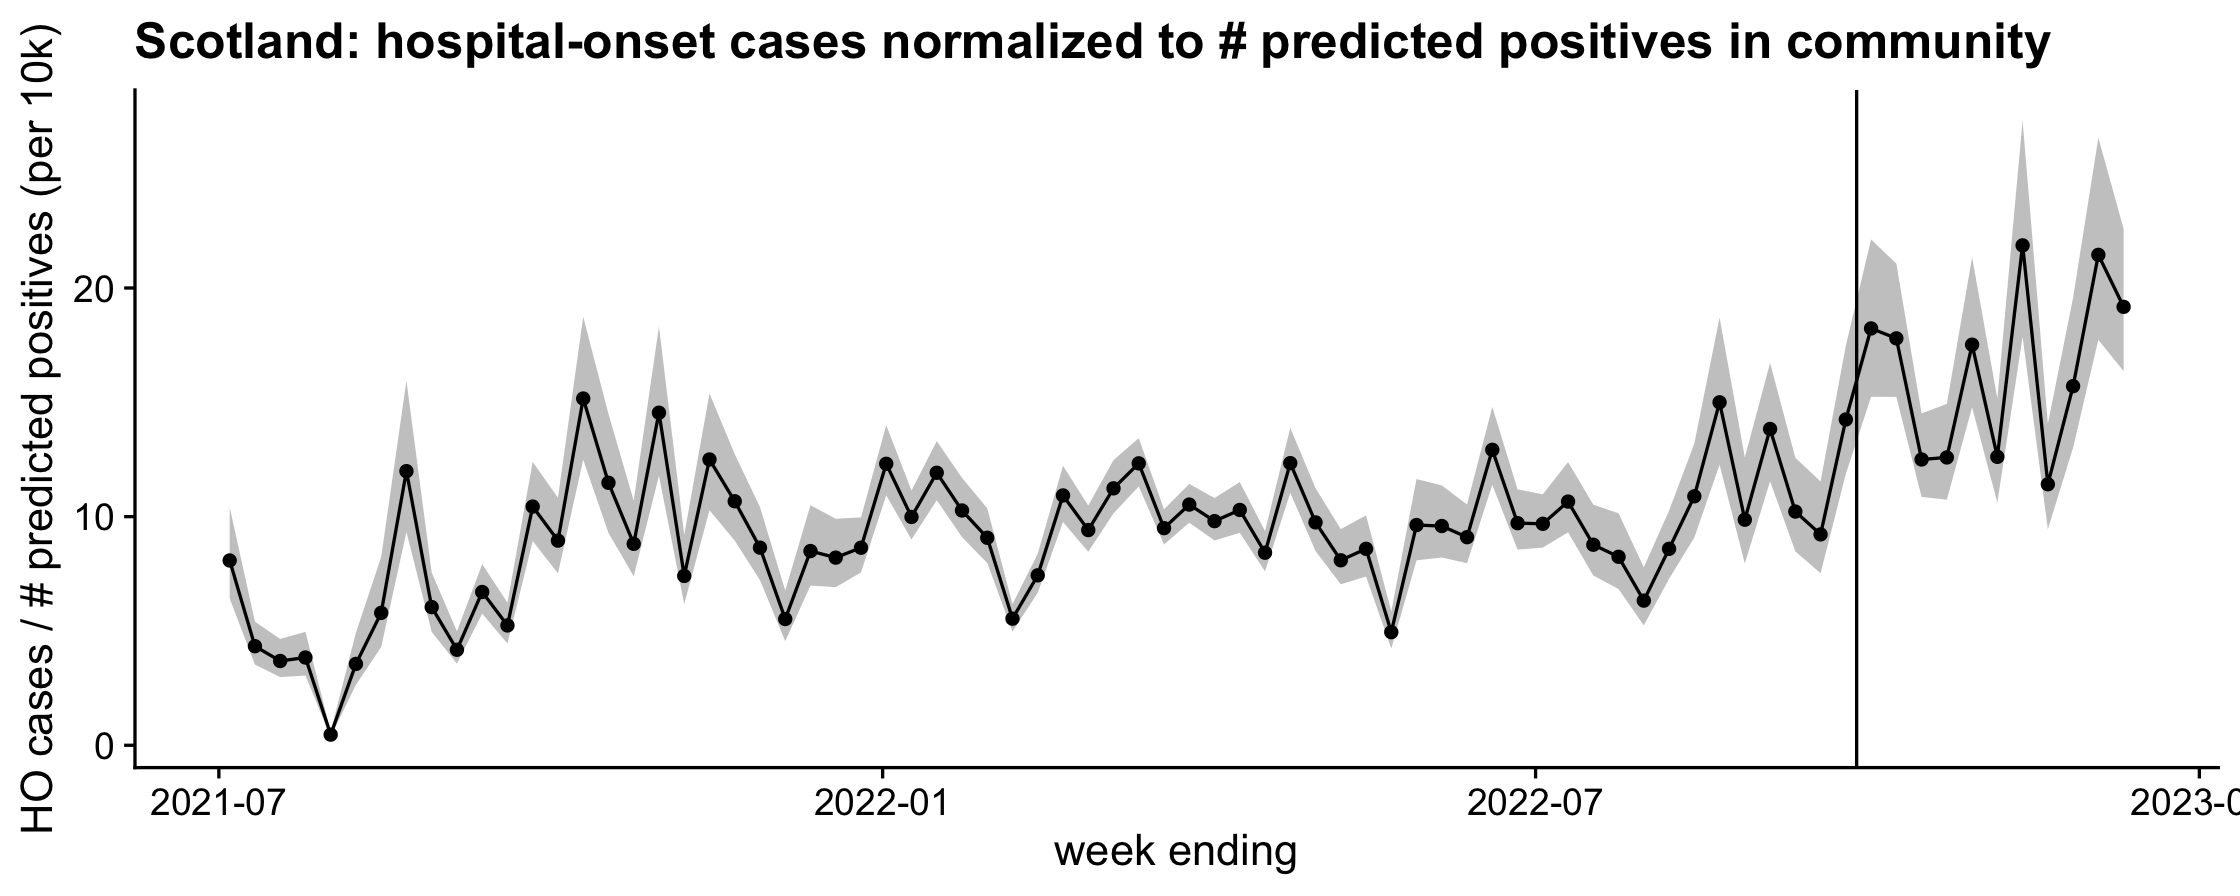

In [19]:
options(repr.plot.width=10, repr.plot.height=4)
ggplot(dt.joined[date >= as.Date('2021-07-01'), ], aes(x=date, y=hospital_onset_vs_comm_positives * 1e4)) +
    geom_ribbon(
        aes(
            ymin=hospital_onset_vs_comm_positives_ci95_lo * 1e4, 
            ymax=hospital_onset_vs_comm_positives_ci95_hi * 1e4
        ),
        alpha=0.3
    ) +
    geom_line() + geom_point() +
    geom_vline(xintercept = as.Date("2022-09-28"), linetype = "solid") +
    ylab("HO cases / # predicted positives (per 10k)") + xlab("week ending") +
    ggtitle("Scotland: hospital-onset cases normalized to # predicted positives in community") + 
    theme_cowplot()

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


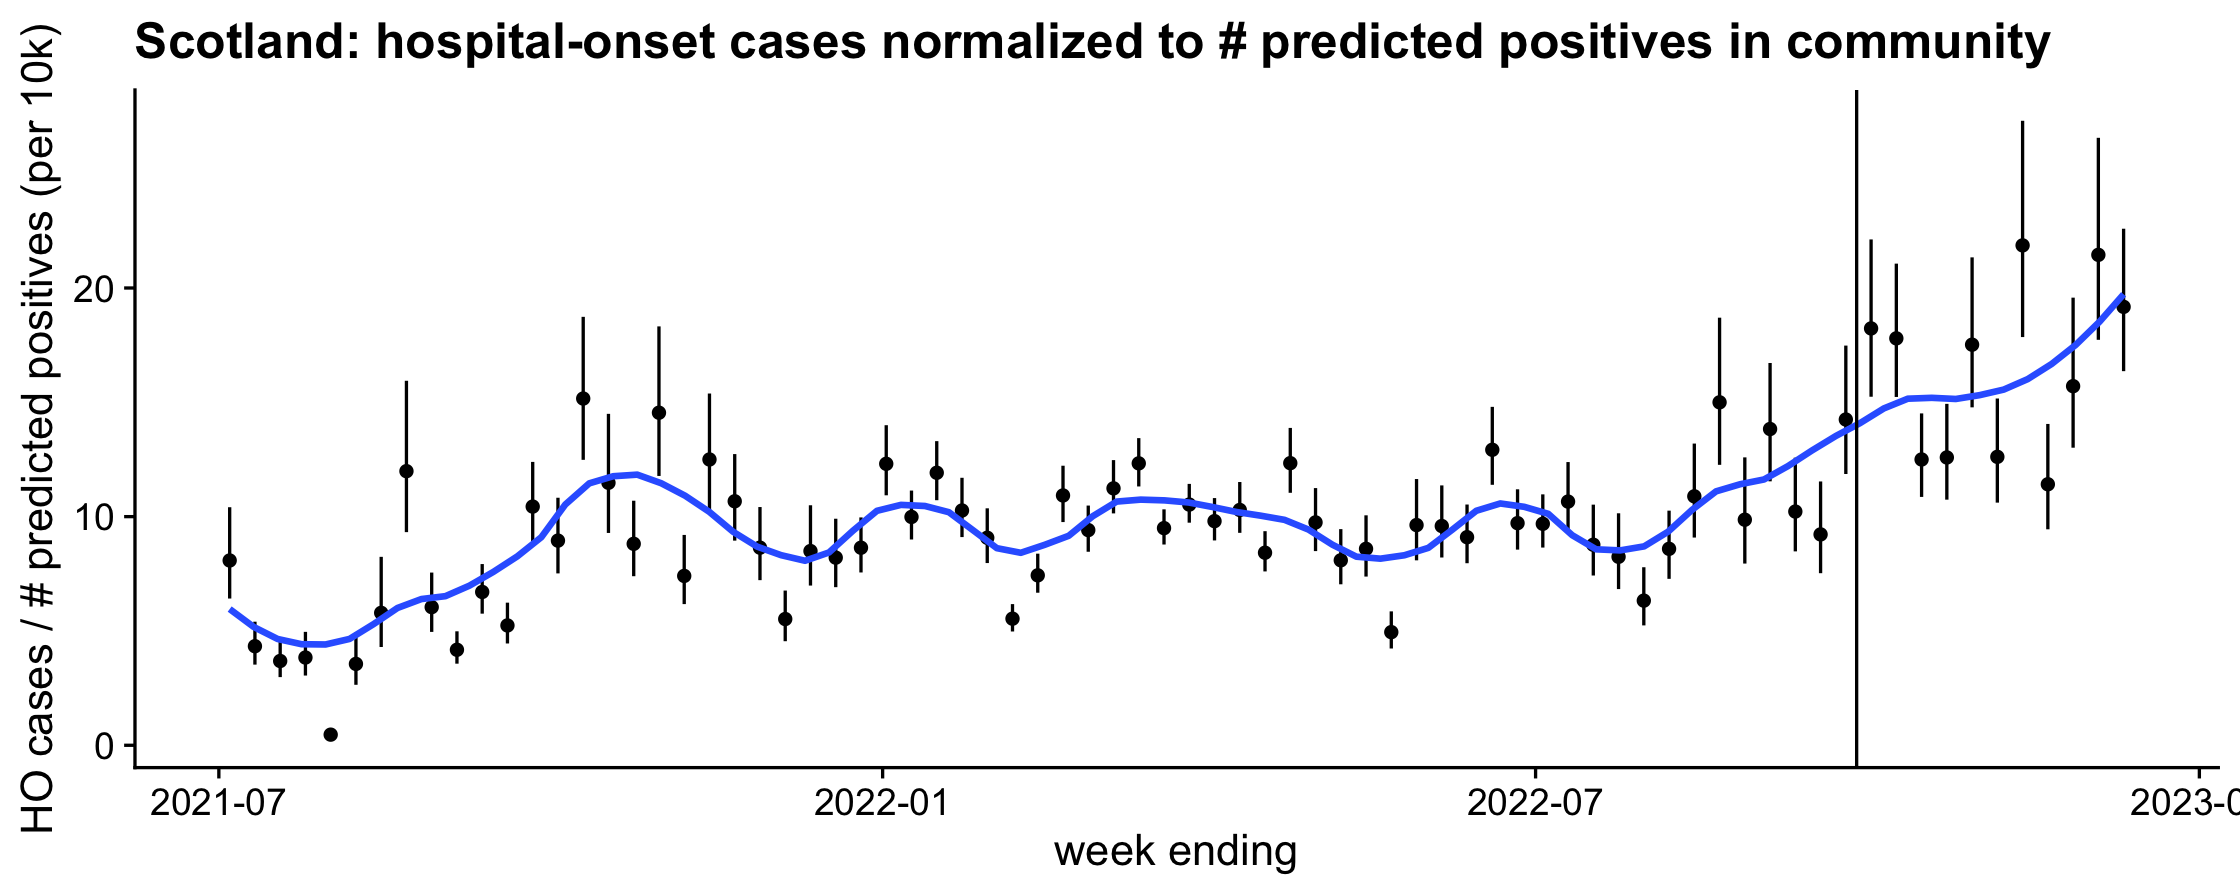

In [20]:
options(repr.plot.width=10, repr.plot.height=4)
ggplot(dt.joined[date >= as.Date('2021-07-01'), ], aes(x=date, y=hospital_onset_vs_comm_positives * 1e4)) +
    geom_point() +
    geom_errorbar(aes(
        ymin=hospital_onset_vs_comm_positives_ci95_lo * 1e4, 
        ymax=hospital_onset_vs_comm_positives_ci95_hi * 1e4,
        width=0
    )) +
    geom_smooth(se=FALSE, span=0.2) +
    geom_vline(xintercept = as.Date("2022-09-28"), linetype = "solid") +
    ylab("HO cases / # predicted positives (per 10k)") + xlab("week ending") +
    ggtitle("Scotland: hospital-onset cases normalized to # predicted positives in community") + 
    theme_cowplot()

# save data; sessionInfo

>Farewell to the Highlands, farewell to the North,  
>The birth-place of Valour, the country of Worth;  
>Wherever I wander, wherever I rove,  
>The hills of the Highlands for ever I love.
>
>— Robert Burns

In [21]:
dt.joined.trimmed <- copy(dt.joined)
dt.joined.trimmed[
    ,
    c("Country", "WeekEnding", "WeekNumber", "ProbableHospitalOnsetCOVID19", "DefiniteHospitalOnsetCOVID19") := NULL
]
colnames(dt.joined.trimmed)

[1] "date_range"                              
 [2] "est_pct_positive"                        
 [3] "est_pct_positive_ci95_lo"                
 [4] "est_pct_positive_ci95_hi"                
 [5] "est_pop_positive"                        
 [6] "est_pop_positive_ci95_lo"                
 [7] "est_pop_positive_ci95_hi"                
 [8] "est_ratio_positive"                      
 [9] "est_ratio_positive_ci95_lo"              
[10] "est_ratio_positive_ci95_hi"              
[11] "date_lo"                                 
[12] "date_hi"                                 
[13] "date"                                    
[14] "community_onset_adm_count"               
[15] "hospital_onset_adm_count"                
[16] "total_covid_adm_count"                   
[17] "hospital_onset_ratio"                    
[18] "hospital_onset_vs_comm_ratio"            
[19] "hospital_onset_vs_comm_positivity"       
[20] "hospital_onset_vs_comm_positives"        
[21] "hospital_onset_vs_comm_positives_ci95_hi"
[22] "hospital_onset_vs_comm_positives_ci95_lo"

In [22]:
dt.joined.trimmed[, region := "Scotland"]
saveRDS(dt.joined.trimmed, file="data/dt.scotland.rds")

In [23]:
sessionInfo()

R version 4.2.1 (2022-06-23)
Platform: aarch64-apple-darwin20 (64-bit)
Running under: macOS Monterey 12.5

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.2-arm64/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.2-arm64/Resources/lib/libRlapack.dylib

locale:
[1] C/UTF-8/C/C/C/C

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] lubridate_1.8.0   cowplot_1.1.1     yaml_2.3.5        viridis_0.6.2    
 [5] viridisLite_0.4.1 readxl_1.4.1      data.table_1.14.5 forcats_0.5.2    
 [9] stringr_1.4.1     dplyr_1.0.10      purrr_1.0.0       readr_2.1.3      
[13] tidyr_1.2.1       tibble_3.1.8      ggplot2_3.4.0     tidyverse_1.3.2  
[17] plyr_1.8.7       

loaded via a namespace (and not attached):
 [1] httr_1.4.4          jsonlite_1.8.0      splines_4.2.1      
 [4] modelr_0.1.9        assertthat_0.2.1    googlesheets4_1.0.1
 [7] cellranger_1.1.0    pill